In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import recommendations
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [2]:
df = pd.read_csv('../datasets/SEHIR/processed_dataset.csv')
df = df[['Student Number', 'Course Code', 'Letter Grade', 'Semester', 'Course Credit']]
df

,Student Number,Course Code,Letter Grade,Semester,Course Credit
0,240,UNI 111,F,2011 - Fall,3
1,338,UNI 107,A,2011 - Fall,3
2,338,UNI 105,A,2011 - Fall,3
3,338,UNI 103,A,2011 - Fall,3
4,240,UNI 105,A,2011 - Fall,3
...,...,...,...,...,...
48736,1102,MGT 531,A-,2014 - Spring,3
48737,1102,MGT 585,A,2014 - Spring,3
48738,1102,MGT 552,A,2014 - Spring,3
48739,1984,MGT 574,A-,2014 - Spring,3


In [3]:
numerical_grades = {'A+': 4.1, 'A': 4.0, 'A-': 3.7, 'B+': 3.3, 'B': 3.0, 'B-': 2.7, 'C+': 2.3, 'C': 2.0,
                    'C-': 1.7, 'D+': 1.3, 'D': 1.0, 'D-': 0.5, 'F': 0.0}

In [4]:
semester_data = {}
course_credits = {}
for row_idx in df.index:
    student_number = df.iloc[row_idx, 0]
    course_code = df.iloc[row_idx, 1]
    letter_grade = df.iloc[row_idx, 2]
    semester = df.iloc[row_idx, 3]
    credit = df.iloc[row_idx, 4]
    
    course_credits[course_code] = credit
    semester_data.setdefault(semester, {})
    semester_data[semester].setdefault(student_number, {})
    semester_data[semester][student_number][course_code] = numerical_grades[letter_grade]

In order to assess the accuracy of the model, we use Root Mean Squared Error (RMSE) which is defined as: 

$$\large \text{RMSE}(y, \hat{y}) = \sqrt{\frac{1}{n_\text{samples}} \sum_{i=0}^{n_\text{samples} - 1} (y_i - \hat{y}_i)^2}$$


The mean_absolute_error function computes mean absolute error, a risk metric corresponding to the expected value of the absolute error loss or $l$1-norm loss. If $\hat{y}_i$ is the predicted value of the $i$-th sample, and $y_i$ is the corresponding true value, then the mean absolute error (MAE) estimated over $n_{\text{samples}}$ is defined as:

$$\large \text{MAE}(y, \hat{y}) = \frac{1}{n_{\text{samples}}} \sum_{i=0}^{n_{\text{samples}}-1} \left| y_i - \hat{y}_i \right|$$

In [5]:
def get_avg_gpa(train_semester, student):
    courses = train_semester[student]
    total_credit = 0
    weights = 0
    for course in courses:
        total_credit += course_credits[course]
        weights += courses[course] * course_credits[course]
    
    return weights / total_credit

In [6]:
def get_course_stats(train_semester):
    """
    Eğitim dönemindeki verilerden derslerin ortalamasını ve 
    hiç veri yoksa kullanılacak genel ortalamayı hesaplar.
    """
    course_grades = {}
    all_grades = []
    
    for student, courses in train_semester.items():
        for course, grade in courses.items():
            course_grades.setdefault(course, []).append(grade)
            all_grades.append(grade)
            
    # Her dersin ortalaması
    course_means = {c: np.mean(g) for c, g in course_grades.items()}
    
    # Tüm verinin ortalaması (Hiç bilinmeyen yeni bir ders gelirse diye)
    global_mean = np.mean(all_grades) if all_grades else 0
    
    return course_means, global_mean

In [7]:
def get_grade_stats(semester_data, student):
    grade_list = []
    
    for course in semester_data[student]:
        numerical_grade = semester_data[student][course]
        grade_list.append(numerical_grade)
    
    mean = np.mean(grade_list)
    std_dev = np.std(grade_list)
    
    return mean, std_dev

In [10]:
def get_errors(train_semester, test_semester, sim, item_based, fallback_strategy='course'):
    average_gpa = {}
    y_true = []
    y_pred = []
    gpa = {}
    
    # Hazırlıklar
    if fallback_strategy == 'course' or fallback_strategy == 'baseline_course': # Baseline için de gerekli
        course_means, global_mean = get_course_stats(train_semester)

    for student in train_semester:
        gpa[student] = get_avg_gpa(train_semester, student)
    
    if item_based:
        item_sims = recommendations.calculateSimilarItems(train_semester)

    for student in train_semester:
        recommended_courses = {}
        
        # --- BASELINE İÇİN HİLE ---
        # Eğer strateji "baseline" ise CF hiç çalışmasın (boş dönsün)
        if fallback_strategy.startswith('baseline'):
            recs = [] 
        else:
            if item_based:
                recs = recommendations.getRecommendedItems(train_semester, item_sims, student)
            else:
                recs = recommendations.getRecommendations(train_semester, student, sim, dgpa=True, gpa=gpa, delta=0.7)
        
        for rec_grade, rec_course in recs:
            recommended_courses.setdefault(rec_course, rec_grade)
            
        average_gpa.setdefault(student, get_avg_gpa(train_semester, student))
        
        if student not in test_semester:
            continue
        
        mean, std_dev = get_grade_stats(train_semester, student)
            
        for course_code in test_semester[student]:
            final_pred = None
            
            # 1. CF Tahmini Var mı?
            if course_code in recommended_courses:
                final_pred = recommended_courses[course_code]
            
            # 2. Yoksa Fallback'e git
            else:
                if fallback_strategy == 'course' or fallback_strategy == 'baseline_course':
                    final_pred = course_means.get(course_code, global_mean)
                elif fallback_strategy == 'student' or fallback_strategy == 'baseline_student':
                    final_pred = average_gpa[student]
                elif fallback_strategy == 'none':
                    continue # Tahmin yoksa atla (RMSE hesabına katma)

            # Outlier Kontrolü (Baseline ve None hariç)
            # Baseline saf ortalamayı göstermeli, outlier silmemeli ki dürüst olsun
            if not fallback_strategy.startswith('baseline'):
                 if final_pred < mean - (2 * std_dev) or final_pred > mean + (2 * std_dev):
                    continue
            
            if final_pred is not None:
                y_pred.append(final_pred)
                y_true.append(test_semester[student][course_code])
            
    # Eğer 'none' seçildiyse ve hiç tahmin yoksa hata vermesin
    if len(y_true) == 0: return 0, 0
    
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    return rmse, mae

In [11]:
def predict(semester_data, sim, item_based=False, fallback_strategy='student'): # Parametre eklendi
    errors = {'rmse': [], 'mae': []}
    train_semester = {}
    
    # Semesterleri sırayla gez (Time-series mantığı)
    for i in range(1, len(sorted(semester_data))):
        prev_sem_key = sorted(semester_data)[i-1]
        curr_sem_key = sorted(semester_data)[i]
        
        new_semester = semester_data[prev_sem_key]
        
        # Training verisini güncelle
        for student in new_semester:
            if student in train_semester:
                train_semester[student].update(new_semester[student])
            else:
                train_semester[student] = new_semester[student]
        
        test_semester = semester_data[curr_sem_key]

        # Tahmin yap (fallback_strategy parametresini get_errors'a ilet)
        rmse, mae = get_errors(train_semester, test_semester, sim, item_based, fallback_strategy)

        errors['rmse'].append(rmse)
        errors['mae'].append(mae)
    
    return errors

In [12]:
def plot_errors(errors, sim):
    x = np.arange(7)
    fig, ax = plt.subplots(figsize=(11, 5.5))
    rects1 = ax.bar(x - 0.35/2, errors['rmse'], 0.35, label='RMSE')
    rects2 = ax.bar(x + 0.35/2, errors['mae'], 0.35, label='MAE')
    for i, v in enumerate(errors['rmse']):
        ax.text(i-0.36, v + 0.01, str(round(v, 2)), fontfamily='serif', fontsize=13, fontweight='bold')
    for i, v in enumerate(errors['mae']):
        ax.text(i-0.01, v + 0.01, str(round(v, 2)), fontfamily='serif', fontsize=13, fontweight='bold')
    ax.set_ylabel('Error', fontsize=22, fontfamily='serif')
    ax.set_title('Error Metrics with N training semesters ({})'.format(sim), fontsize=22, fontfamily='serif')
    ax.set_xticks(x)
    ax.set_xticklabels(['N={}'.format(i+1) for i in range(7)], fontsize=22, fontfamily='serif')
    ax.set_yticklabels([round(i,1) for i in ax.get_yticks()], fontsize=22, fontfamily='serif')
    ax.tick_params(labelsize=22)
    ax.grid(True)
    ax.legend(prop={'size': 18, 'family': 'serif'}, loc='center', bbox_to_anchor=(0.5, -0.15), ncol=2)

### User-based Collaborative Filtering

In [13]:
results = {}

The euclidean distance between all points $p$ and $q$ are given by:

$$\large d\left( p,q\right)   = \sqrt {\sum _{i=1}^{n}  \left( q_{i}-p_{i}\right)^2 }$$

where d( $p$,$q$ ) is 0 when $p$ = $q$. In order to show a high numerical value for close points, we make the following division:

$$\large d\left( p,q\right)   = \frac{1}{1 + d\left( p,q\right)}$$

In [ ]:
errors = predict(semester_data, recommendations.sim_distance)
results['Euclidean Distance'] = errors
plot_errors(errors, 'Euclidean Distance')

The Jaccard index, also known as Intersection over Union and the Jaccard similarity coefficient, is a statistic used for gauging the similarity and diversity of sample sets. The Jaccard coefficient measures similarity between finite sample sets, and is defined as the size of the intersection divided by the size of the union of the sample sets:

$$\large J(A,B) = \frac{|A \cap B|}{|A \cup B|}$$

In [ ]:
errors = predict(semester_data, recommendations.sim_jaccard)
results['Jaccard Index'] = errors
plot_errors(errors, 'Jaccard Index')

The correlation coefficient is a measure of how well two sets of data fit on a straight line. The formula for this is more complicated than the Euclidean distance score, but it tends to give better results in situations where the data isn’t well normalized. 


$$\large r=\frac{n(\sum xy)-(\sum x)(\sum y)}{\sqrt{[n\sum x^{2}-(\sum x)^{2}][n\sum y^{2}-(\sum y)^{2}]}}$$

where $x$ corresponds to values in the first set of data and $y$ corresponds to the other one. $n$ determines the total number of samples.

In [ ]:
errors = predict(semester_data, recommendations.sim_pearson)
results['Pearson Correlation'] = errors
plot_errors(errors, 'Pearson Correlation')

In [13]:
with open('baseline_collaborative_filtering_results (user-based).json', 'w') as fw:
    json.dump(results, fw)

### Item-based Collaborative Filtering

In [14]:
results = {}

In [ ]:
errors = predict(semester_data, recommendations.sim_distance, item_based=True)
results['Euclidean Distance'] = errors

In [ ]:
plot_errors(errors, 'Euclidean Distance')

In [ ]:
errors = predict(semester_data, recommendations.sim_jaccard, item_based=True)
results['Jaccard Index'] = errors

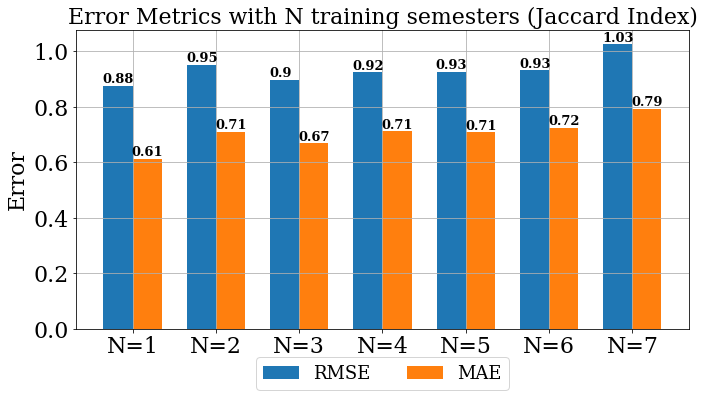

In [18]:
plot_errors(errors, 'Jaccard Index')

In [ ]:
errors = predict(semester_data, recommendations.sim_pearson, item_based=True)
results['Pearson Correlation'] = errors

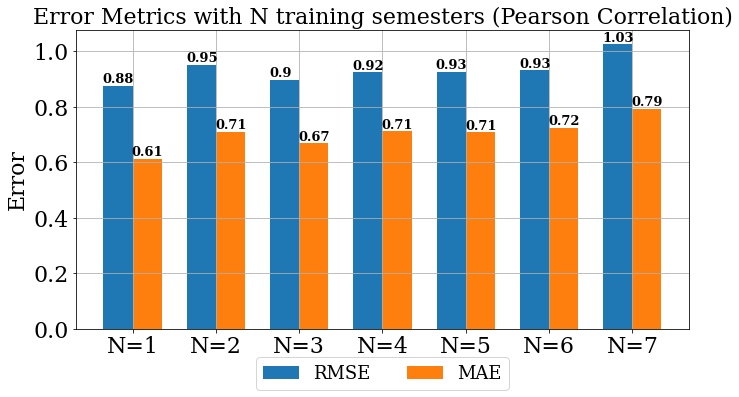

In [20]:
plot_errors(errors, 'Pearson Correlation')

In [21]:
with open('baseline_collaborative_filtering_results (item-based).json', 'w') as fw:
    json.dump(results, fw)

# subset uzerinde calisma 

In [ ]:
import json
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
import recommendations  # Kendi kütüphaneniz

# --- MASKE YÜKLE ---
with open('subset_fallback_mask.json', 'r') as f:
    valid_mask = json.load(f)

# --- CUSTOM FONKSİYON: Parametreli calculateSimilarItems ---
# recommendations.py içindeki fonksiyonu override ediyoruz
def calculateSimilarItems_custom(prefs, n=10, similarity=recommendations.sim_pearson):
    result = {}
    
    # Kullanıcı-Item matrisini ters çevir (Item-Kullanıcı yap)
    # transformPrefs fonksiyonu recommendations dosyasında olmalı
    itemPrefs = recommendations.transformPrefs(prefs)
    
    c = 0
    for item in itemPrefs:
        c += 1
        # Orijinal dosyadaki topMatches fonksiyonunu istediğimiz benzerlik metriğiyle çağırıyoruz
        scores = recommendations.topMatches(itemPrefs, item, n=n, similarity=similarity)
        result[item] = scores
        
    return result

# --- MASKELİ HATA HESABI ---
def get_errors_masked_baseline(train_semester, test_semester, sim_function, is_item_based, current_sem_name, mask):
    y_true = []
    y_pred = []
    
    # Öğrenci Ortalamaları (Fallback için)
    gpa = {}
    for student in train_semester:
        scores = [float(v) for v in train_semester[student].values()]
        if scores:
            gpa[student] = sum(scores) / len(scores)
        else:
            gpa[student] = 0
            
    # --- ITEM-BASED İÇİN MATRİS HESABI ---
    item_sims = None
    if is_item_based:
        # DÜZELTME BURADA: Artık kendi yazdığımız custom fonksiyonu kullanıyoruz
        item_sims = calculateSimilarItems_custom(train_semester, n=10, similarity=sim_function)

    # Test Öğrencileri İçin Tahmin
    for student in test_semester:
        if student not in train_semester:
            continue
            
        # --- TAHMİN ALMA ---
        if is_item_based:
            recs = recommendations.getRecommendedItems(train_semester, item_sims, student)
        else:
            # User-Based zaten parametre kabul ediyor
            recs = recommendations.getRecommendations(train_semester, student, similarity=sim_function)
            
        recommended_courses = {r[1]: r[0] for r in recs}
        
        # Öğrencinin testteki dersleri
        for course_code in test_semester[student]:
            
            # --- MASKE (SUBSET) KONTROLÜ ---
            is_valid = False
            student_str = str(student)
            
            if current_sem_name in mask:
                if student_str in mask[current_sem_name]:
                    if course_code in mask[current_sem_name][student_str]:
                        is_valid = True
            
            if not is_valid:
                continue
            # -------------------------------
            
            final_pred = None
            if course_code in recommended_courses:
                final_pred = recommended_courses[course_code]
            else:
                final_pred = gpa.get(student, 0) # Fallback
            
            # Outlier Kontrolü
            vals = [float(v) for v in train_semester[student].values()]
            if vals:
                mean_val = sum(vals) / len(vals)
                std_dev = np.std(vals)
                if std_dev > 0: # 0'a bölme hatasını önle
                    if final_pred < mean_val - (2 * std_dev) or final_pred > mean_val + (2 * std_dev):
                        continue

            y_pred.append(final_pred)
            y_true.append(test_semester[student][course_code])
            
    return y_true, y_pred

# --- ANA ÇALIŞTIRMA FONKSİYONU ---
def run_cf_analysis(semester_data, mask):
    # Metrik Listesi
    metrics = [
        ("Euclidean Distance", recommendations.sim_distance),
        ("Pearson Correlation", recommendations.sim_pearson),
        ("Jaccard Index", recommendations.sim_jaccard) 
    ]
    
    # Sonuçları Tutacak Sözlükler
    results_user_based = {m[0]: {"rmse": [], "mae": []} for m in metrics}
    results_item_based = {m[0]: {"rmse": [], "mae": []} for m in metrics}
    
    sorted_semesters = sorted(semester_data.keys())
    
    print("CF Analysis Running on Subset...")
    
    # Dönem Döngüsü (i=1'den başla)
    for i in range(1, len(sorted_semesters)):
        curr_sem_name = sorted_semesters[i]
        
        print(f"--> Processing Semester: {curr_sem_name}")
        
        # Train Verisini Oluştur (Kümülatif)
        train_semester = {}
        for k in range(i):
            sem_name = sorted_semesters[k]
            sem_data = semester_data[sem_name]
            for student in sem_data:
                if student in train_semester:
                    train_semester[student].update(sem_data[student])
                else:
                    train_semester[student] = sem_data[student].copy()
        
        test_semester = semester_data[curr_sem_name]
        
        # --- METRİK DÖNGÜSÜ ---
        for metric_name, sim_func in metrics:
            # print(f"    Metric: {metric_name}")
            
            # 1. User-Based
            y_true_u, y_pred_u = get_errors_masked_baseline(
                train_semester, test_semester, sim_func, 
                is_item_based=False, current_sem_name=curr_sem_name, mask=mask
            )
            
            if len(y_true_u) > 0:
                rmse_u = np.sqrt(mean_squared_error(y_true_u, y_pred_u))
                mae_u = mean_absolute_error(y_true_u, y_pred_u)
            else:
                rmse_u, mae_u = 0, 0
                
            results_user_based[metric_name]["rmse"].append(rmse_u)
            results_user_based[metric_name]["mae"].append(mae_u)
            
            # 2. Item-Based (Custom Fonksiyon ile)
            y_true_i, y_pred_i = get_errors_masked_baseline(
                train_semester, test_semester, sim_func, 
                is_item_based=True, current_sem_name=curr_sem_name, mask=mask
            )
            
            if len(y_true_i) > 0:
                rmse_i = np.sqrt(mean_squared_error(y_true_i, y_pred_i))
                mae_i = mean_absolute_error(y_true_i, y_pred_i)
            else:
                rmse_i, mae_i = 0, 0
                
            results_item_based[metric_name]["rmse"].append(rmse_i)
            results_item_based[metric_name]["mae"].append(mae_i)
            
    return results_user_based, results_item_based

# --- ÇALIŞTIR ---
# semester_data değişkeninin yüklü olduğundan emin ol
res_user, res_item = run_cf_analysis(semester_data, valid_mask)

# --- KAYDET ---
with open('results_baseline_cf_user_based_subset.json', 'w') as f:
    json.dump(res_user, f, indent=4)

with open('results_baseline_cf_item_based_subset.json', 'w') as f:
    json.dump(res_item, f, indent=4)

print("✅ Başarıyla tamamlandı! Dosyalar kaydedildi.")

CF Analysis Running on Subset...
--> Processing Semester: 2011 - Spring
--> Processing Semester: 2012 - Fall
--> Processing Semester: 2012 - Spring
--> Processing Semester: 2013 - Fall
--> Processing Semester: 2013 - Spring
--> Processing Semester: 2014 - Fall
--> Processing Semester: 2014 - Spring
✅ Başarıyla tamamlandı! Dosyalar kaydedildi.
